In [1]:
# Notebook Imports
import os
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.stats as stats
from fredapi import Fred

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    mean_squared_error
)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Notebook Settings
plt.style.use('seaborn-v0_8')

In [2]:
# Window Parameters
_1_WEEK_WINDOW = 5    # 1 trading week
_1_MONTH_WINDOW = 21  # 1 trading month
_3_MONTH_WINDOW = 63  # 3 trading months
_6_MONTH_WINDOW = 126 # 6 trading months
_1_YEAR_WINDOW = 252  # 1 trading year

_MONTH_TO_YEAR = 12
HORIZON = _1_MONTH_WINDOW

IEF = 'IEF' # 7-10 year treasury bond ETF

In [3]:
# Initialize FRED API
fred = Fred(api_key='4e885cf121aa26a26db1c20165591b45')

[*********************100%***********************]  1 of 1 completed


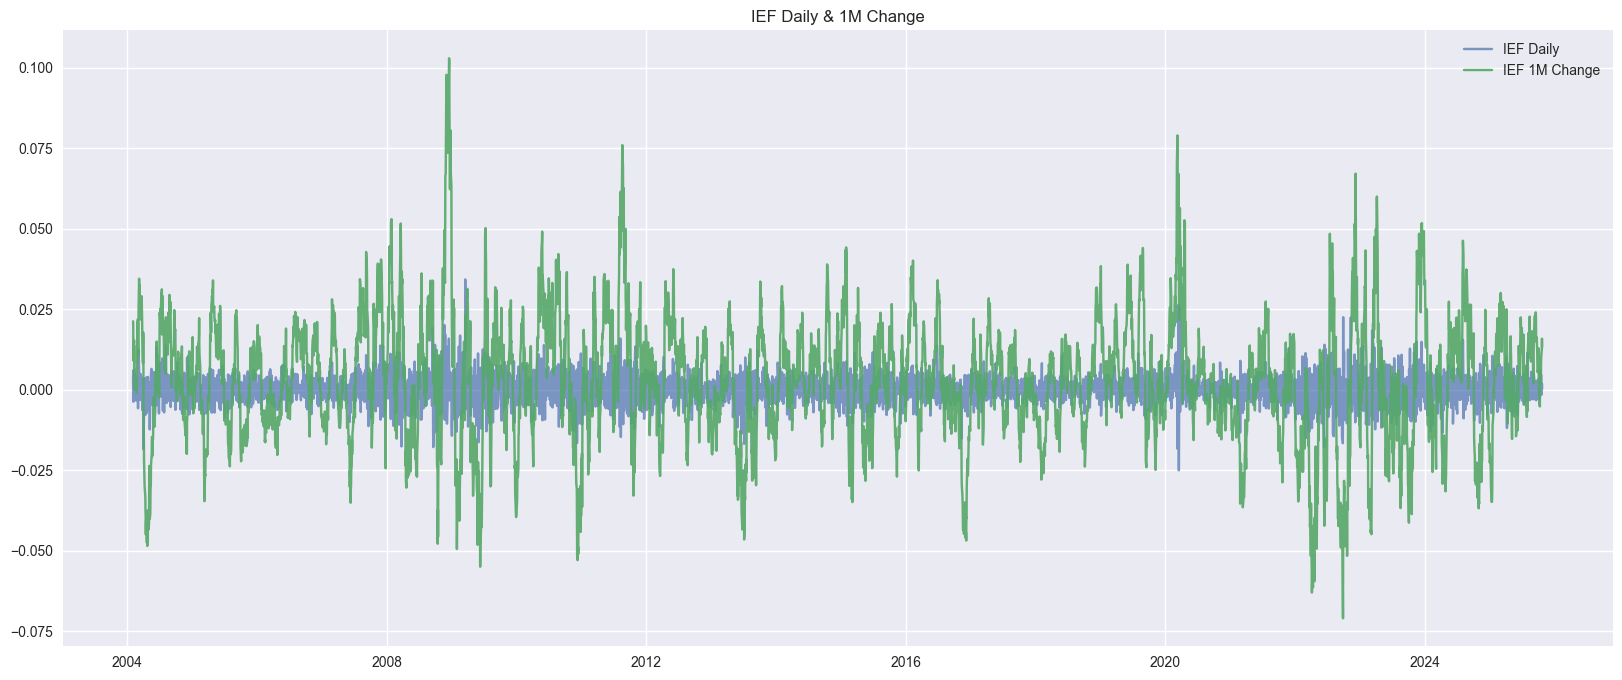

In [4]:
# Set the symbol
SYMBOL = IEF

# Define date range
start = "2004-01-01"                           # Start date for data
end = dt.datetime.today().strftime('%Y-%m-%d') # Today

# Download returns
asset = yf.download(SYMBOL, start=start, end=end, auto_adjust=True)['Close']
asset[f'{SYMBOL}_ret'] = asset[SYMBOL].pct_change()
asset[f'{SYMBOL}_roll'] = asset[SYMBOL].pct_change(_1_MONTH_WINDOW)
asset.dropna(inplace=True)

# Plot the time series return data
plt.figure(figsize=(20, 8))
plt.plot(asset[f'{SYMBOL}_ret'], alpha=0.7, label=f'{SYMBOL} Daily')
plt.plot(asset[f'{SYMBOL}_roll'], alpha=0.9, label=f'{SYMBOL} 1M Change')
plt.title(f'{SYMBOL} Daily & 1M Change')
plt.legend()
plt.show()

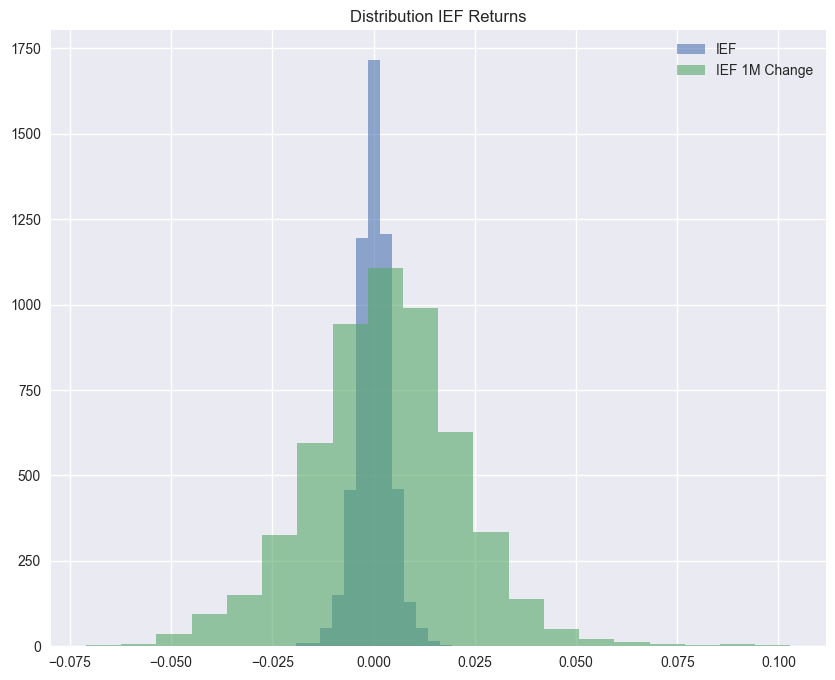

In [5]:
# Plot the distribution of TLT returns
plt.figure(figsize=(10, 8))
plt.hist(asset[f'{SYMBOL}_ret'], bins=20, alpha=0.6, label=f'{SYMBOL}')
plt.hist(asset[f'{SYMBOL}_roll'], bins=20, alpha=0.6, label=f'{SYMBOL} 1M Change')
plt.title(f"Distribution {SYMBOL} Returns")
plt.legend()
plt.show()

In [6]:
fred_series = {
    "GS10": "10-Year Treasury Constant Maturity Rate",
    "GS2": "2-Year Treasury Constant Maturity Rate",
    "DGS30": "30-Year Treasury Constant Maturity Rate",
    "T10YIE": "10-Year Breakeven Inflation Rate",
    "FEDFUNDS": "Effective Federal Funds Rate",
    "CPIAUCSL": "Consumer Price Index for All Urban Consumers",
    "UNRATE": "Unemployment Rate"
}

# Download the macro data
macro = pd.DataFrame({s: fred.get_series(s, observation_start=start) for s in fred_series.keys()})
macro.index = pd.to_datetime(macro.index)

# Resample the data to daily
# NOTE: Some of the FRED data is only reported on a monthly basis. FFill is used to avoid lookahead bias
# NOTE: Ffill propogates the last observed value forward
macro = macro.ffill()

print(macro.head())

# Merge asset and macro on the date index
data = pd.merge(asset, macro, left_index=True, right_index=True, how='inner')

            GS10   GS2  DGS30  T10YIE  FEDFUNDS  CPIAUCSL  UNRATE
2004-01-01  4.15  1.76    NaN     NaN       1.0     186.3     5.7
2004-01-02  4.15  1.76   5.30    2.32       1.0     186.3     5.7
2004-01-05  4.15  1.76   5.28    2.35       1.0     186.3     5.7
2004-01-06  4.15  1.76   5.26    2.32       1.0     186.3     5.7
2004-01-07  4.15  1.76   5.22    2.33       1.0     186.3     5.7


In [7]:
def compute_rsi(series, window=14):
    """ Relative Strength Index """

    delta = series.diff()  # daily change
    gain = delta.clip(lower=0)  # only positive changes
    loss = -delta.clip(upper=0)  # only negative changes
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Yield curve spreads
data['YC_10Y_2Y'] = data['GS10'] - data['GS2']
data['YC_30Y_10Y'] = data['DGS30'] - data['GS10']

# Macro changes
data['FEDFUNDS_1m'] = data['FEDFUNDS'].pct_change(_1_MONTH_WINDOW)
data['UNRATE_1m'] = data['UNRATE'].pct_change(_1_MONTH_WINDOW)

# Momentum features
data[f'{SYMBOL}_mom_1m'] = data[f'{SYMBOL}'] / data[f'{SYMBOL}'].shift(_1_MONTH_WINDOW-1) - 1
data[f'{SYMBOL}_mom_3m'] = data[f'{SYMBOL}'] / data[f'{SYMBOL}'].shift(_3_MONTH_WINDOW-1) - 1

# Distribution features
data[f'{SYMBOL}_mean_1m'] = data[f'{SYMBOL}_ret'].rolling(_1_MONTH_WINDOW).mean().shift(1)
data[f'{SYMBOL}_mean_3m'] = data[f'{SYMBOL}_ret'].rolling(_3_MONTH_WINDOW).mean().shift(1)
data[f'{SYMBOL}_vol_1m'] = data[f'{SYMBOL}_ret'].rolling(_1_MONTH_WINDOW).std().shift(1)
data[f'{SYMBOL}_vol_3m'] = data[f'{SYMBOL}_ret'].rolling(_3_MONTH_WINDOW).std().shift(1)
data[f'{SYMBOL}_skew_1m'] = data[f'{SYMBOL}_ret'].rolling(_1_MONTH_WINDOW).skew().shift(1)
data[f'{SYMBOL}_skew_3m'] = data[f'{SYMBOL}_ret'].rolling(_3_MONTH_WINDOW).skew().shift(1)
data[f'{SYMBOL}_kurt_1m'] = data[f'{SYMBOL}_ret'].rolling(_1_MONTH_WINDOW).kurt().shift(1)
data[f'{SYMBOL}_kurt_3m'] = data[f'{SYMBOL}_ret'].rolling(_3_MONTH_WINDOW).kurt().shift(1)

# Technical features
data['RSI'] = compute_rsi(data[f'{SYMBOL}'], _1_MONTH_WINDOW).shift(1)

# Inflation momentum
data['CPI_YoY'] = data['CPIAUCSL'].pct_change(_MONTH_TO_YEAR)

# Clean data
data.dropna(inplace=True)

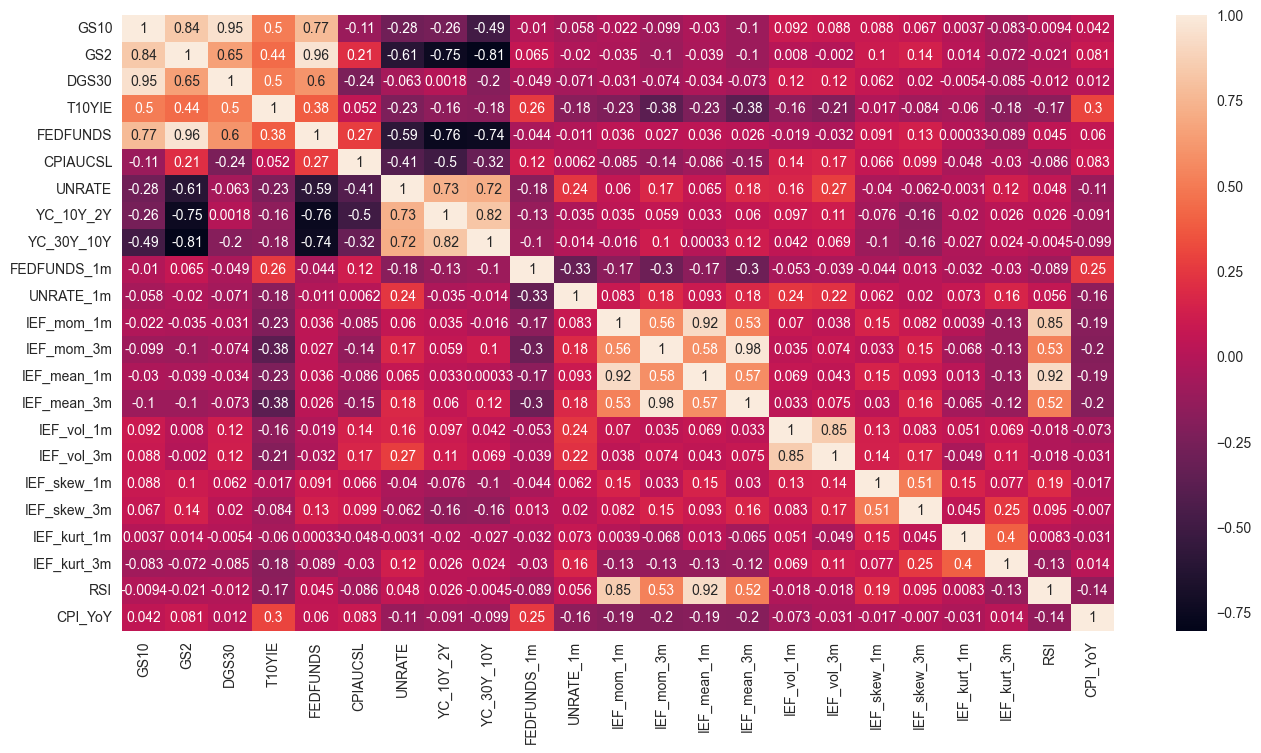

In [8]:
# Only plot the correlations of the features
NON_COLS = [f'{SYMBOL}', f'{SYMBOL}_roll', f'{SYMBOL}_ret']

feature_cols = [x for x in data.columns if x not in NON_COLS]
plt.figure(figsize=(16, 8))
sns.heatmap(data[feature_cols].corr(), annot=True)
plt.show()

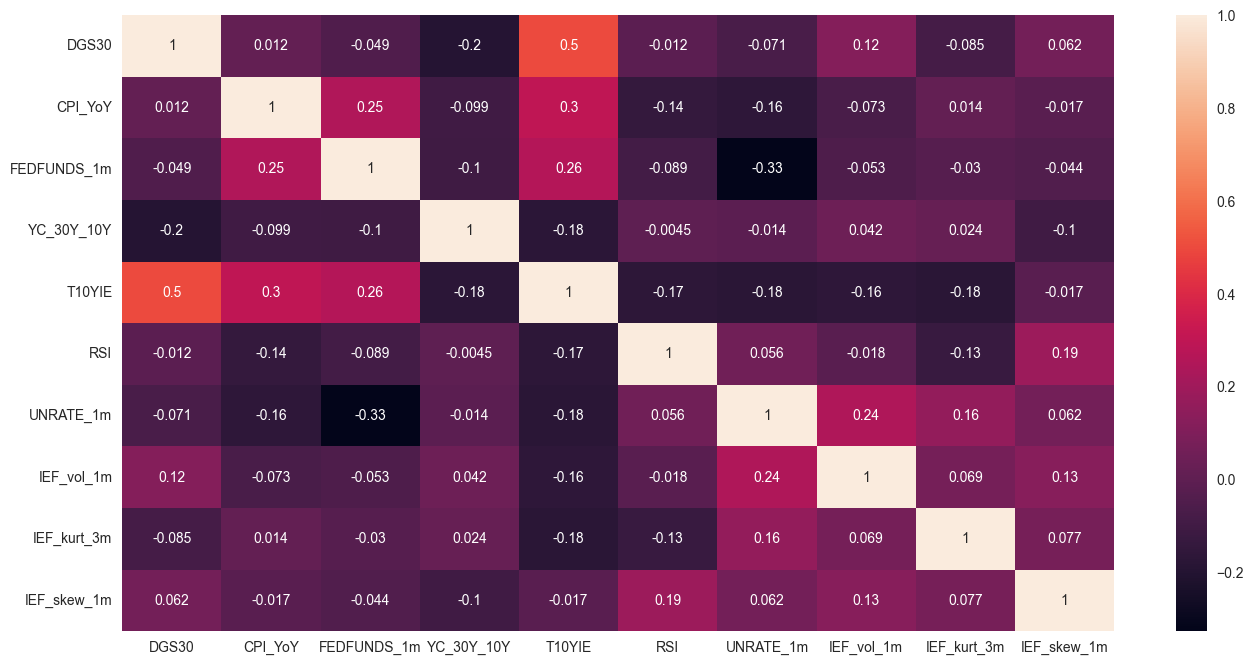

In [9]:
# Plot the feature correlation table
# NOTE: We remove highly correlated features
IEF_COLS = ['DGS30', 'CPI_YoY', 'FEDFUNDS_1m', 'YC_30Y_10Y', 'T10YIE', 'RSI', 'UNRATE_1m',
            f'{SYMBOL}_vol_1m', f'{SYMBOL}_kurt_3m', f'{SYMBOL}_skew_1m']

feature_cols = IEF_COLS
plt.figure(figsize=(16, 8))
sns.heatmap(data[feature_cols].corr(), annot=True)
plt.show()

In [10]:
# NOTE: 80% train, 20% test for static model
split = int(len(data) * 0.8)

# Create the response and response labels
# NOTE: Value of return t+HORIZON is now at t
# NOTE: This aligns the future return with the current date
data['Future_ret_1m'] = data[f'{SYMBOL}'].pct_change(HORIZON).shift(-HORIZON)

# Define the regime
# NOTE: we are only using the training data to compute the quantiles
upper_q = data['Future_ret_1m'].iloc[:split].quantile(0.6)
lower_q = data['Future_ret_1m'].iloc[:split].quantile(0.4)

# Top 40% of returns (long)
# Bottom 40% of returns (short)
# Middle 20% of returns (sign of future return)
data['Regime'] = 0
data.loc[data['Future_ret_1m'] > upper_q, 'Regime'] = 1

# Set the middle 20% regime
middle_mask = data['Future_ret_1m'].between(lower_q, upper_q)
data.loc[middle_mask, 'Regime'] = (data.loc[middle_mask, 'Future_ret_1m'] > 0).astype(int)

print(data['Regime'].value_counts())

Regime
1    3110
0    2293
Name: count, dtype: int64


In [11]:
# Set the features and response names
features = feature_cols
response = 'Regime'

print(features)
print(response)

['DGS30', 'CPI_YoY', 'FEDFUNDS_1m', 'YC_30Y_10Y', 'T10YIE', 'RSI', 'UNRATE_1m', 'IEF_vol_1m', 'IEF_kurt_3m', 'IEF_skew_1m']
Regime


In [12]:
# Split the train and test data
X = data[features]
y = data[response]

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

random_forest = RandomForestClassifier(
    n_estimators = 500,
    max_depth = 4,
    min_samples_leaf = 0.05,
    random_state = 42,
    max_features = 'sqrt',
    oob_score = True,
)

# Fit the model to training data
random_forest.fit(X_train, y_train)

# Make test predictions
predictions = random_forest.predict(X_test)

# Add the predictions (next 1M to data)
data.loc[X_test.index, 'Predicted_regime'] = predictions

# Determine the strategy positions, compute returns
# NOTE: shift(1) moves the predicted regime "down" by one day, taking the previous day's prediction.
# NOTE: This ensures we are only creating a position the day after the prediction is made. (prevent look-ahead bias)
data['Position'] = data['Predicted_regime'].shift(1).apply(lambda x: 1 if x == 1 else -1)
data['Strategy_ret'] = data['Position'] * data[f'{SYMBOL}_ret']

strategy_df = data.loc[X_test.index].copy()

strategy_df['Strategy_cum_ret'] = (1 + strategy_df['Strategy_ret']).cumprod()
strategy_df[f'{SYMBOL}_cum_ret'] = (1 + strategy_df[f'{SYMBOL}_ret']).cumprod()

In [13]:
# Strategy and index metrics
strategy_sharpe = (strategy_df['Strategy_ret'].mean() / strategy_df['Strategy_ret'].std()) * np.sqrt(_1_YEAR_WINDOW)
index_sharpe = (strategy_df[f'{SYMBOL}_ret'].mean() / strategy_df[f'{SYMBOL}_ret'].std()) * np.sqrt(_1_YEAR_WINDOW)

strategy_cagr = (strategy_df['Strategy_cum_ret'].iloc[-1]) ** (_1_YEAR_WINDOW / len(strategy_df)) - 1
index_cagr = (strategy_df[f'{SYMBOL}_cum_ret'].iloc[-1]) ** (_1_YEAR_WINDOW / len(strategy_df)) - 1

strategy_volatility = strategy_df['Strategy_ret'].std() * np.sqrt(_1_YEAR_WINDOW)
index_volatility = strategy_df[f'{SYMBOL}_ret'].std() * np.sqrt(_1_YEAR_WINDOW)

print(f'Strategy vs {SYMBOL} Performance')
print(f'SHARPE: {strategy_sharpe:.4f} | {index_sharpe:.4f}')
print(f'CAGR:   {strategy_cagr:.4f} | {index_cagr:.4f}')
print(f'VOLATI: {strategy_volatility:.4f} | {index_volatility:.4f}')

Strategy vs IEF Performance
SHARPE: -0.0119 | -0.1122
CAGR:   -0.0042 | -0.0123
VOLATI: 0.0809 | 0.0809


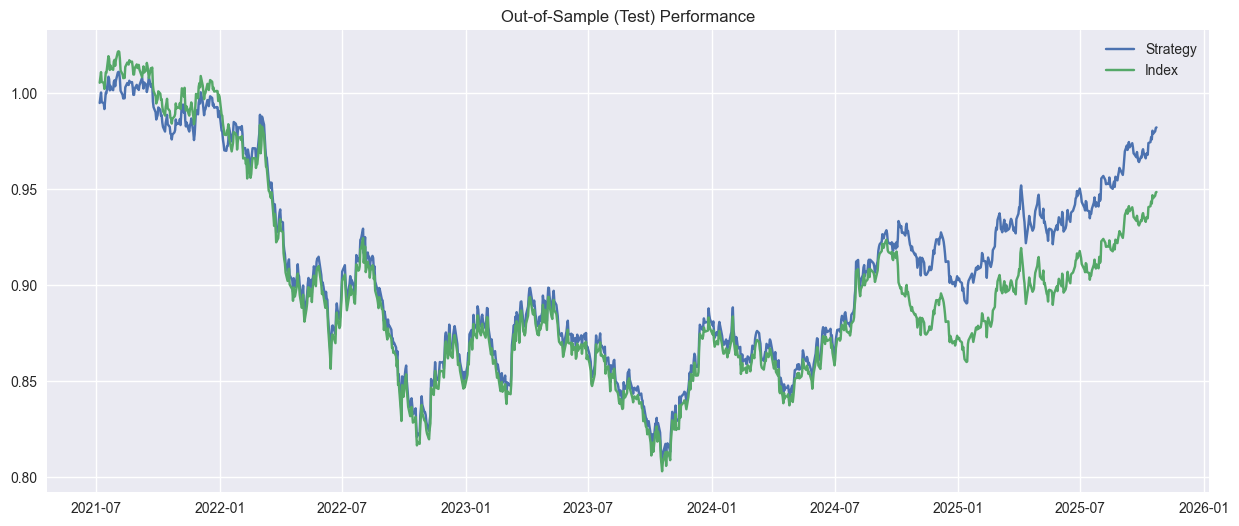

In [14]:
plt.figure(figsize=(15, 6))
plt.title('Out-of-Sample (Test) Performance')
plt.plot(strategy_df['Strategy_cum_ret'], label='Strategy')
plt.plot(strategy_df[f'{SYMBOL}_cum_ret'], label='Index')
plt.legend()
plt.show()

In [15]:
# Evaluate the random forest model
y_predicted = random_forest.predict(X_test)
y_probability = random_forest.predict_proba(X_test)

# Model metrics
print(f"Accuracy: {accuracy_score(y_test, y_predicted):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_predicted)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_predicted)}")

Accuracy: 0.5116
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.06       544
           1       0.50      1.00      0.67       537

    accuracy                           0.51      1081
   macro avg       0.75      0.51      0.36      1081
weighted avg       0.75      0.51      0.36      1081

Confusion Matrix:
[[ 16 528]
 [  0 537]]


DGS30          0.259504
CPI_YoY        0.122669
FEDFUNDS_1m    0.144336
YC_30Y_10Y     0.080366
T10YIE         0.061767
RSI            0.019367
UNRATE_1m      0.024771
IEF_vol_1m     0.183594
IEF_kurt_3m    0.056242
IEF_skew_1m    0.047384
dtype: float64


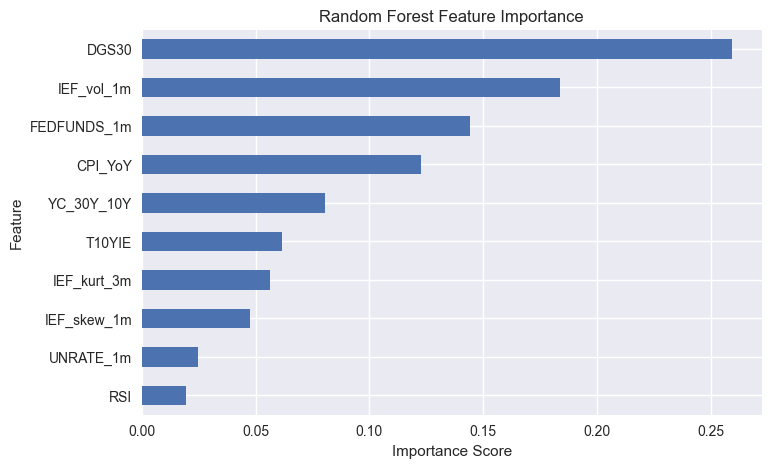

In [16]:
# Feature importance
important_features = pd.Series(random_forest.feature_importances_, index=X.columns)
print(important_features)

important_features.sort_values().plot(kind='barh', figsize=(8, 5))
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [17]:
# 10-fold cross validation
n = 10
tcsv = TimeSeriesSplit(n_splits=n)

# Accuracy for classification
cv_scores = cross_val_score(random_forest, X_train, y_train, cv=tcsv, scoring='accuracy')

print(f'Cross-Validation Scores ({n}-fold): {cv_scores}')
print(f'CV Variation: {np.std(cv_scores)}')
print(f'Mean CV Accuracy: {np.mean(cv_scores)}')

Cross-Validation Scores (10-fold): [0.57397959 0.50510204 0.66326531 0.58163265 0.61479592 0.50765306
 0.56377551 0.53316327 0.625      0.60969388]
CV Variation: 0.049337684392438096
Mean CV Accuracy: 0.5778061224489797


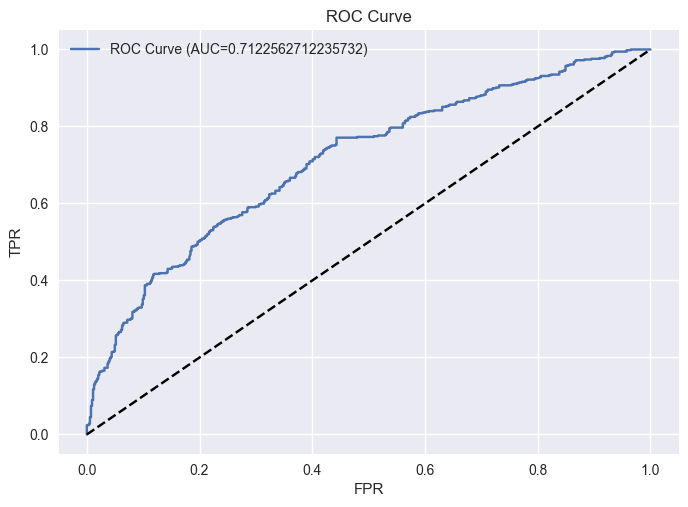

In [18]:
# fpr - false positive rate
# tpr - true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_probability[:, 1])
roc_auc = roc_auc_score(y_test, y_probability[:, 1])

plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc})')
plt.plot([0,1], [0,1], 'k--') # Diagonal
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [19]:
oob_error = 1 - random_forest.oob_score_

print(f'OOB: {random_forest.oob_score_}')
print(f'OOB Error: {oob_error}')

OOB: 0.6536325775104118
OOB Error: 0.3463674224895882


In [20]:
# Get the train and test accuracy
train_acc = random_forest.score(X_train, y_train)
test_acc = random_forest.score(X_test, y_test)

print(train_acc - test_acc)

0.1536379284438929


Train Dates 2004-05-04 00:00:00 <-> 2009-05-05 00:00:00 | Test Date 2009-05-06 00:00:00: -1 (ret=0.00836829518148352) (exp=(-1.0))
Train Dates 2004-05-05 00:00:00 <-> 2009-05-06 00:00:00 | Test Date 2009-05-07 00:00:00: -1 (ret=-0.0011897703802405957) (exp=(-1.0))
Train Dates 2004-05-06 00:00:00 <-> 2009-05-07 00:00:00 | Test Date 2009-05-08 00:00:00: -1 (ret=-0.0094016015648557) (exp=(-1.0))
Train Dates 2004-05-07 00:00:00 <-> 2009-05-08 00:00:00 | Test Date 2009-05-11 00:00:00: -1 (ret=0.0006424370592275075) (exp=(-1.0))
Train Dates 2004-05-10 00:00:00 <-> 2009-05-11 00:00:00 | Test Date 2009-05-12 00:00:00: -1 (ret=-0.004607901758766575) (exp=(-1.0))
Train Dates 2004-05-11 00:00:00 <-> 2009-05-12 00:00:00 | Test Date 2009-05-13 00:00:00: -1 (ret=-0.00010627671957141871) (exp=(-1.0))
Train Dates 2004-05-12 00:00:00 <-> 2009-05-13 00:00:00 | Test Date 2009-05-14 00:00:00: -1 (ret=0.0024518889475583228) (exp=(-1.0))
Train Dates 2004-05-13 00:00:00 <-> 2009-05-14 00:00:00 | Test Date 20

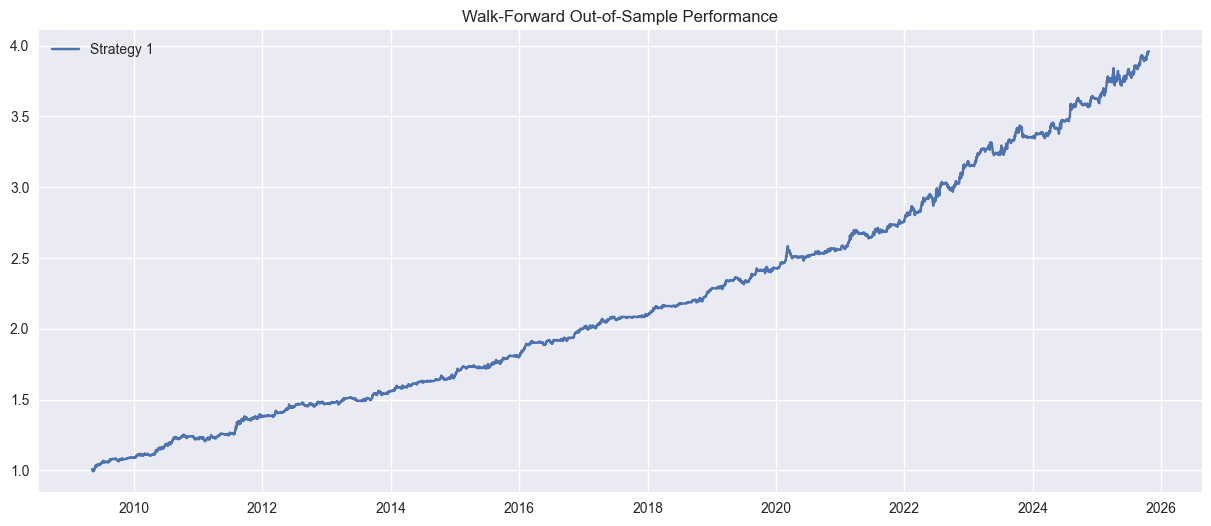

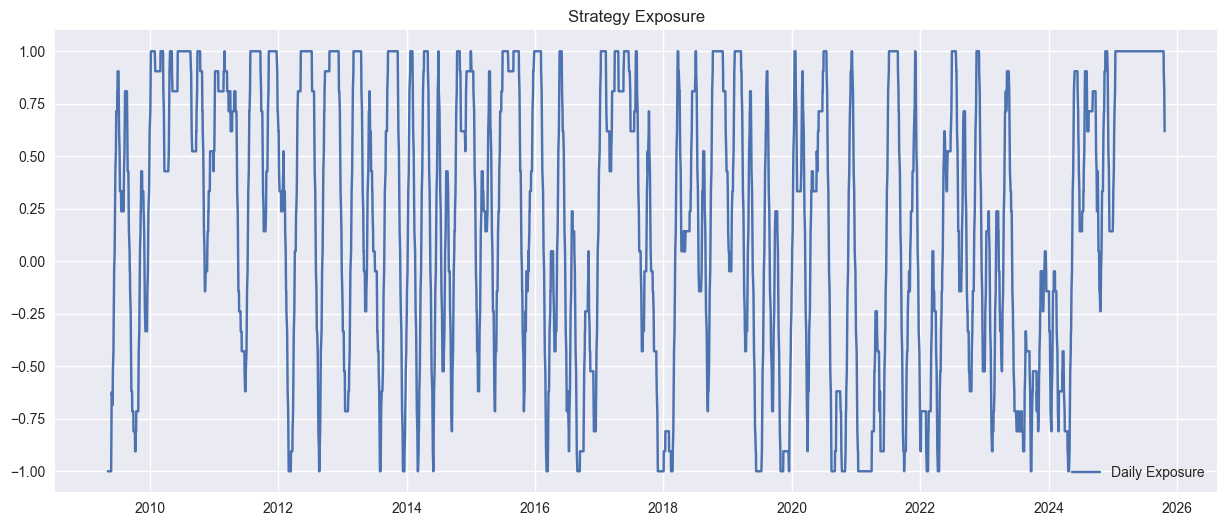

Backtest Metrics ==========
Sharpe: Strategy 1=1.8953
CAGR:   Strategy 1=0.0873
Vol:    Strategy 1=0.0447
Max Drawdown: Strategy 1=-0.0396


In [ ]:
# Backtest parameters
train_window = 5 * _1_YEAR_WINDOW    # 5 years of training
holding_period = _1_MONTH_WINDOW
p_allocation = 1 / holding_period

# Backtest (walk-forward) results
wf_index = []
wf_predictions = []
wf_positions = []
wf_strategy_ret = []
wf_probabilities = []
wf_actuals = []

# Tracks the current position and number of days held
# NOTE: 1 for long
# NOTE: -1 for short
# NOTE: 0 for initialization (until first rebalance)
active_positions = []

log = True

for i in range(train_window, len(X)-1):
    # Get the training data
    train_start = i - train_window
    train_end = i

    # NOTE: X excludes the train_end row
    X_train = X.iloc[train_start:train_end]
    future_ret_train = data['Future_ret_1m'].iloc[train_start:train_end]
    y_train = pd.Series(0, index=future_ret_train.index)

    # Define the historical regimes
    upper_q = future_ret_train.quantile(0.6)
    lower_q = future_ret_train.quantile(0.4)
    middle_mask = future_ret_train.between(lower_q, upper_q)

    y_train.loc[future_ret_train > upper_q] = 1
    y_train.loc[middle_mask] = (future_ret_train[middle_mask] > 0).astype(int)

    y_actual = int(data['Future_ret_1m'].iloc[train_end] > 0)

    # Train the random forest model
    rf = RandomForestClassifier(
        n_estimators = 300,
        max_depth = 8,
        min_samples_leaf = 0.05,
        max_features = 'sqrt',
        random_state = 42
    )
    rf.fit(X_train, y_train)

    # Predict next month's regime
    X_next = X.iloc[[train_end]] # last known observation
    pred_next = rf.predict(X_next)[0]
    prob_next = rf.predict_proba(X_next)[0, 1]
    position = 1 if pred_next == 1 else -1
    active_positions.append(position)

    if len(active_positions) > holding_period:
        active_positions.pop(0)

    # NOTE: Uses i+1 to avoid lookahead bias
    # NOTE: Each position's return is scaled by the portfolio allocation
    exposure = np.mean(active_positions)
    daily_ret = exposure * data[f'{SYMBOL}_ret'].iloc[i+1]

    if log:
        print(f"Train Dates {X.index[train_start]} <-> {X.index[train_end-1]} | Test Date {X.index[train_end]}: {position} (ret={daily_ret}) (exp=({exposure}))")

    # Store strategy results
    wf_index.append(X.index[i+1])
    wf_positions.append(exposure)
    wf_strategy_ret.append(daily_ret)

# Backtest results
wf_results = pd.DataFrame({
    'Position': wf_positions,
    'Strategy_1_ret': wf_strategy_ret
}, index=wf_index)

wf_results['Strategy_1_cum'] = (1 + wf_results['Strategy_1_ret']).cumprod()

# Plot backtest results
plt.figure(figsize=(15,6))
plt.plot(wf_results['Strategy_1_cum'], label='Strategy 1')
plt.title("Walk-Forward Out-of-Sample Performance")
plt.legend()
plt.show()

# Plot positions (exposures)
plt.figure(figsize=(15,6))
plt.plot(wf_results['Position'], label='Daily Exposure')
plt.title("Strategy Exposure")
plt.legend()
plt.show()

# Backtest metrics
def max_drawdown(cum_returns):
    rolling_max = cum_returns.cummax()
    drawdown = cum_returns / rolling_max - 1
    return drawdown.min()

# Strategy 1 metrics
sharpe_strategy_1 = (wf_results['Strategy_1_ret'].mean() / wf_results['Strategy_1_ret'].std()) * np.sqrt(_1_YEAR_WINDOW)
cagr_strategy_1 = (wf_results['Strategy_1_cum'].iloc[-1]) ** (_1_YEAR_WINDOW / len(wf_results)) - 1
vol_strategy_1 = wf_results['Strategy_1_ret'].std() * np.sqrt(_1_YEAR_WINDOW)

print("Backtest Metrics ==========")
print(f"Sharpe: Strategy 1={sharpe_strategy_1:.4f}")
print(f"CAGR:   Strategy 1={cagr_strategy_1:.4f}")
print(f"Vol:    Strategy 1={vol_strategy_1:.4f}")
print(f"Max Drawdown: Strategy 1={max_drawdown(wf_results['Strategy_1_cum']):.4f}")

In [26]:
wf_strategy_ret = np.array(wf_strategy_ret)
pos_returns = wf_strategy_ret[np.where(wf_strategy_ret > 0)]
neg_returns = wf_strategy_ret[np.where(wf_strategy_ret < 0)]

win_loss = len(pos_returns) / len(neg_returns)

mean_return = np.mean(wf_strategy_ret)
mean_pos_return = np.mean(pos_returns)
mean_neg_return = np.mean(neg_returns)

print(f'Positive Returns: {len(pos_returns)}')
print(f'Negative Returns: {len(neg_returns)}')
print(f'Mean Daily Return: {mean_return}')
print(f'Mean Positive Return: {mean_pos_return}')
print(f'Mean Negative Return: {mean_neg_return}')
print(f'Win-Loss Ratio: {win_loss}')

Positive Returns: 2233
Negative Returns: 1878
Mean Daily Return: 0.0003362818028374664
Mean Positive Return: 0.0021469319376471374
Mean Negative Return: -0.0018110861498473229
Win-Loss Ratio: 1.1890308839190629
